To this, we consider SideSeeing dataset folder structure added the folders `/images` and `/clicks` in each instance.

To segment we use segment anything 2 (SAM2).

In [6]:
# build environment
!git clone https://github.com/facebookresearch/sam2.git
!cd sam2 && pip install -e .

Obtaining file:///home/suayder/paper-urbanaccess2024/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-2.5.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metada

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [2]:
# load model and data
from sam2.build_sam import build_sam2_video_predictor
from sideseeing_tools import sideseeing

ds_path = '/scratch/suayder/urbanaccess'
ds = sideseeing.SideSeeingDS(root_dir=ds_path)

# download the checkpoint if you need https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)



INFO. Loading data.
WARNING. /scratch/suayder/urbanaccess/./metadata.csv has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/params_suayder.json has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/1912.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/1.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/8453.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/2094.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/2276.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block01-2024-03-07-14-18-22-116/clicks/2458.txt has been ignored.
WARNING. /scratch/suayder/urbanaccess/./data/Santos_HM/Block0

frame loading (JPEG):   2%|▏         | 25/1200 [00:01<01:48, 10.79it/s]

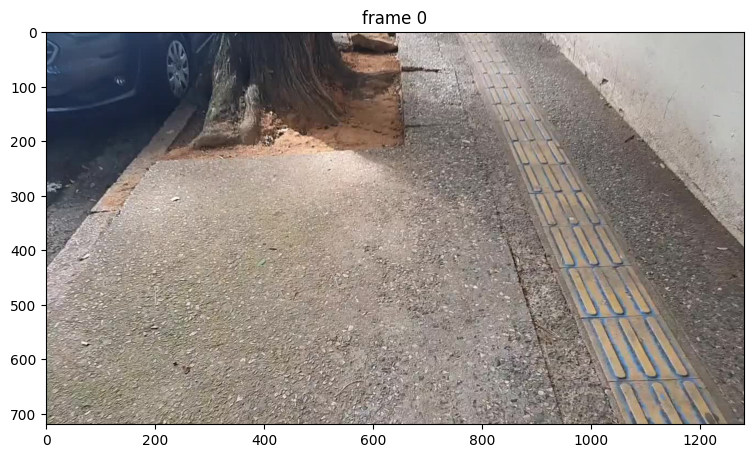

frame loading (JPEG): 100%|██████████| 1200/1200 [01:19<00:00, 15.07it/s]


In [3]:
from sideseeing_tools.sideseeing import SideSeeingInstance
import matplotlib.pyplot as plt

def load_click_data(instance: SideSeeingInstance):
    click_path = os.path.join(instance.path, 'clicks')
    clicks = {}
    cpaths = sorted([i for i in os.listdir(click_path) if i.endswith('.txt')], key=lambda p: int(os.path.splitext(p)[0]))

    for p in cpaths:
        with open(os.path.join(click_path, p)) as f:
            l = f.readline()
            l = list( map(int, l.split(',')) )
            frame_number = int(os.path.splitext(p)[0])
            clicks[frame_number] = l
    return clicks
    

def load_instance_data(instance: SideSeeingInstance):
    image_dir = os.path.join(instance.path, 'images')
    
    # scan all the JPEG frame names in this directory
    frame_names = [
        p for p in os.listdir(image_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
    
    def display_first_frame():
        frame_idx = 0
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {frame_idx}")
        plt.imshow(Image.open(os.path.join(image_dir, frame_names[frame_idx])))

    display_first_frame()

    inference_state = predictor.init_state(video_path=image_dir, async_loading_frames=True)

    return frame_names, inference_state

def load_clicks_to_predictor(instance, inference_state):
    clicks = load_click_data(instance)
    ann_obj_id = 1 # always the same object, if a different class it should be changed

    for click_frame in clicks:
        point = np.array([clicks[click_frame]], dtype=np.float32)
    
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=click_frame-1,
            obj_id=ann_obj_id,
            points=point,
            labels=np.array([1], np.int32),
        )

    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # render the segmentation results every few frames
    vis_frame_stride = 30
    plt.close("all")
    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(instance.path, 'images', frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

def segment_instance(instance, frame_names, inference_state):
    
   pass
    

# instance = ds.instance
# frame_names, inference_state = load_instance_data(instance)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [5]:
load_clicks_to_predictor(instance, inference_state)


Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


propagate in video:   1%|          | 7/1200 [00:07<22:57,  1.15s/it]WARNING:py.warnings:/home/suayder/miniconda3/envs/urbanaccess/lib/python3.10/site-packages/torch/nn/modules/module.py:1747: UserWarning: Flash Attention kernel failed due to: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 7.79 GiB of which 1.48 GiB is free. Including non-PyTorch memory, this process has 6.30 GiB memory in use. Of the allocated memory 5.41 GiB is allocated by PyTorch, and 222.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 7.79 GiB of which 1.48 GiB is free. Including non-PyTorch memory, this process has 6.30 GiB memory in use. Of the allocated memory 5.41 GiB is allocated by PyTorch, and 222.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)